# TIW Cruise Sections

## TODO

CTD at 1m resolution

ADCP in 8m/10m bins

- [x] Need to figure the times when the CTD was taken
- [x] Detect MLD from 1m density profile and mask that out
- [x] plot profiles next to SST
- [ ] make sure I'm using the right ADCP profile or average while the ship was stationary
- [ ] Use PCHIP derivative?
- [ ] download MUR snapshots
- [ ] get high res data
- [x] do reduced shear? works nicely with proper norm

Improvements:
- [ ] -110W assumption in cruise reading file

Look at CCHDO CTD sections and plot over OISST to see if some of these sections can be used to estimate Ri during a TIW in 2N-5N range

In [ ]:
import pump
import dcpy
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tqdm
import xarray as xr

In [ ]:
import distributed

client = distributed.Client()

In [ ]:
client.cluster

## Read all data

In [ ]:
%ls ../datasets/ctd

0_pr16_n_nc_ctd/       21_pr16_q_nc_ctd/         33_pr16_cc_nc_ctd/
10_pr16_ee_nc_ctd/     22_pr16_2003a_nc_ctd/     34_pr16_2005a_nc_ctd/
11_pr16_s_nc_ctd/      23_pr16_w_nc_ctd/         35_pr16_y_nc_ctd/
12_pr16_a_nc_ctd/      24_pr16_20060330_nc_ctd/  3_pr16_ff_nc_ctd/
13_pr16_2004b_nc_ctd/  25_pr16_l_nc_ctd/         4_pr16_aa_nc_ctd/
14_pr16_b_nc_ctd/      26_pr16_o_nc_ctd/         5_pr16_m_nc_ctd/
15_pr16_k_nc_ctd/      27_pr16_u_nc_ctd/         6_pr16_2004a_nc_ctd/
16_pr16_dd_nc_ctd/     28_pr16_h_nc_ctd/         7_pr16_2003b_nc_ctd/
17_pr16_p_nc_ctd/      29_pr16_c_nc_ctd/         8_pr16_g_nc_ctd/
18_pr16_e_nc_ctd/      2_pr16_v_nc_ctd/          9_pr16_z_nc_ctd/
19_pr16_r_nc_ctd/      30_pr15_2005b_nc_ctd/     p18_33RO20071215_ctd/
1_pr16_0a_nc_ctd/      31_pr16_t_nc_ctd/         p18_33RO20161119_ctd/
20_pr16_bb_nc_ctd/     32_pr16_f_nc_ctd/         zips/


In [ ]:
import glob

dirname = "../datasets/ctd/*ctd"
cruises = pump.sections.read_cruise_folders(dirname)

oisst = xr.open_mfdataset(
    "../glade/obs/oisst/*.nc", combine="nested", concat_dim="time", parallel=True
)
oisst = (
    oisst.assign(lon=oisst.lon - 360).sel(lat=slice(-8, 8), lon=slice(-155, -90)).sst
)

adcp_files = sorted(glob.glob("../datasets/adcp/*.nc"))
adcp_files

100%|██████████| 38/38 [01:24<00:00,  2.24s/it]


## CTD

### MLD computation

In [ ]:
cruises[0].density.load()

<xarray.DataArray 'density' (latitude: 13, pressure: 2008)>
array([[          nan, 1021.61466996, 1021.61580471, ..., 1027.67752305,
        1027.67758485, 1027.67800753],
       [          nan, 1021.48973679, 1021.49817825, ...,           nan,
                  nan,           nan],
       [          nan, 1021.77406458, 1021.774826  , ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan, 1022.28975995, ...,           nan,
                  nan,           nan],
       [1022.22953715, 1022.22816024, 1022.22996723, ...,           nan,
                  nan,           nan],
       [          nan, 1022.39740448, 1022.39668462, ...,           nan,
                  nan,           nan]])
Coordinates:
    longitude  int64 -110
  * pressure   (pressure) float64 3.0 4.0 5.0 ... 2.008e+03 2.009e+03 2.01e+03
    time       (latitude) datetime64[ns] 1991-04-03T12:48:00 ... 1991-04-08T03:48:00
  * latitude   (latitude) float64 4.966 5.041 4.007 ... -2.997 -3.994 -4.953

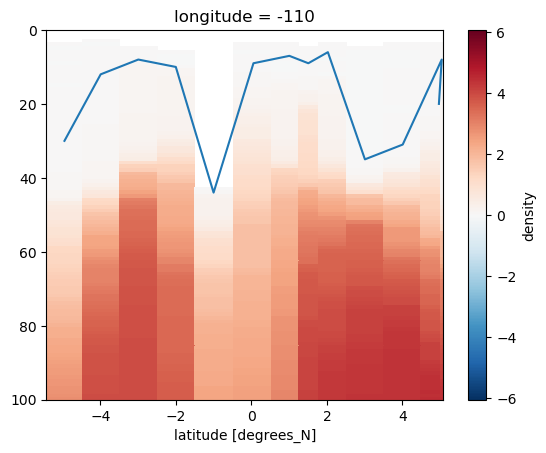

In [ ]:
rho = cruises[0].density
drho = rho - rho.bfill("pressure").isel(pressure=0)
mld = xr.where(drho > 0.015, drho.pressure, np.nan).min("pressure")

drho.sortby("latitude").plot(x="latitude", ylim=(100, 0))
mld.plot(x="latitude")

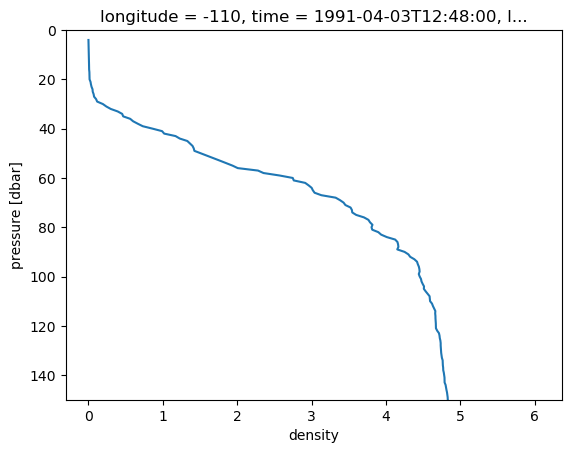

In [ ]:
%matplotlib inline

drho.isel(latitude=0).plot(ylim=(150, 0), y="pressure", yincrease=False)

## ADCP

In [ ]:
ctd = pump.sections.find_cruise(cruises, "31DSEP393")
# ctd["latitude"] = np.round(ctd.latitude, 1)
ctd

Found 31DSEP393 at index 24.


<xarray.Dataset>
Dimensions:         (latitude: 22, pressure: 1008)
Coordinates:
    longitude       int64 -110
  * pressure        (pressure) float64 3.0 4.0 5.0 ... 1.009e+03 1.01e+03
    time            (latitude) datetime64[ns] 1993-09-07T01:31:00 ... 1993-09-14T10:09:00
  * latitude        (latitude) float64 -8.007 -7.0 -6.0 ... 8.032 8.998 10.01
Data variables:
    pressure_QC     (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    temperature     (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    temperature_QC  (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    salinity        (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    salinity_QC     (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    oxygen          (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    oxygen_QC       (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    woce_date       (latitude) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    woce_time       (latitude) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    station         (latitude) |S40 b'20' b'21' b'22' ... b'39' b'40' b'41'
    cast            (latitude) |S40 b'1' b'1' b'1' b'1' ... b'1' b'1' b'1' b'1'
    density         (latitude, pressure) float64 dask.array<chunksize=(1, 1008), meta=np.ndarray>
    mld             (latitude) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    EXPOCODE:                   31DSEP393_1
    Conventions:                COARDS/WOCE
    WOCE_VERSION:               3.0
    WOCE_ID:                    PR16
    DATA_TYPE:                  WOCE CTD
    STATION_NUMBER:             20
    CAST_NUMBER:                1
    BOTTOM_DEPTH_METERS:        0
    Creation_Time:              Diggs Code Version 1.2: Mon Aug 26 19:47:34 2...
    ORIGINAL_HEADER:            :CTD,20020826WHPOSIOHLB:#Software Version: CT...
    WOCE_CTD_FLAG_DESCRIPTION:  ::1=Not calibrated:2=Acceptable measurement:3...

### processing

Found 31DSEP393 at index 24.


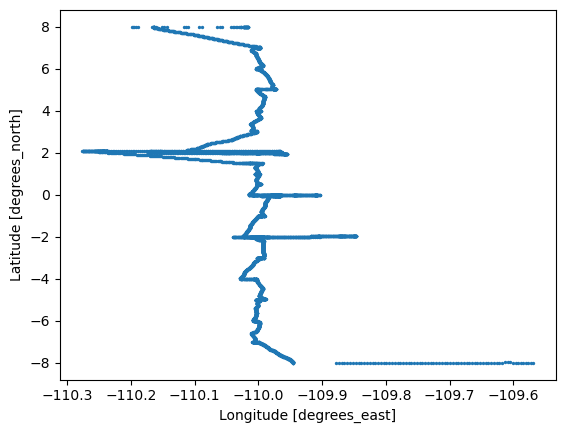

In [ ]:
adcp = pump.sections.read_adcp(
    "../datasets/adcp/31DSEP393_1_00210_short.nc", -110, debug=True
)
ctd = pump.sections.find_cruise(cruises, "31DSEP393")
# ctd["density"] = dcpy.eos.pden(ctd.salinity, ctd.temperature, ctd.pressure)
ctd, adcp = pump.sections.trim_ctd_adcp(ctd, adcp)
binned = pump.sections.grid_ctd_adcp(ctd, adcp)
# ctd["latitude"] = np.round(ctd.latitude, 1)

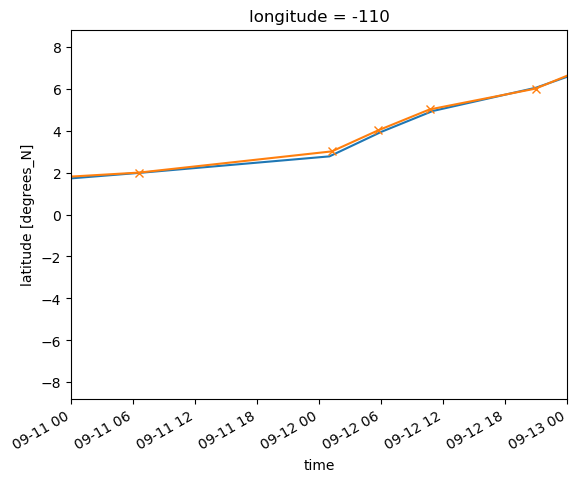

In [ ]:
adcp.latitude.plot(x="time")
ctd.latitude.plot(x="time", marker="x", xlim=("1993-09-11", "1993-09-13"))

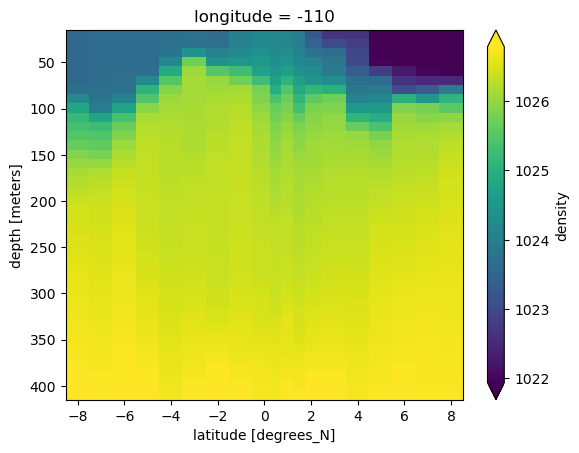

In [ ]:
binned.density.plot(y="depth", yincrease=False, robust=True)

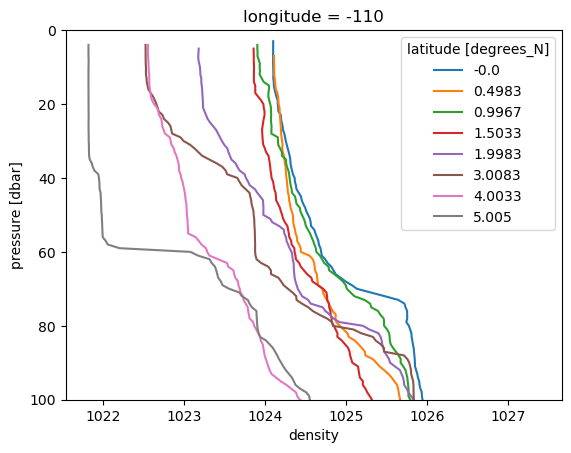

In [ ]:
ctd.density.sel(latitude=slice(0, 6)).plot(hue="latitude", y="pressure", ylim=(100, 0))

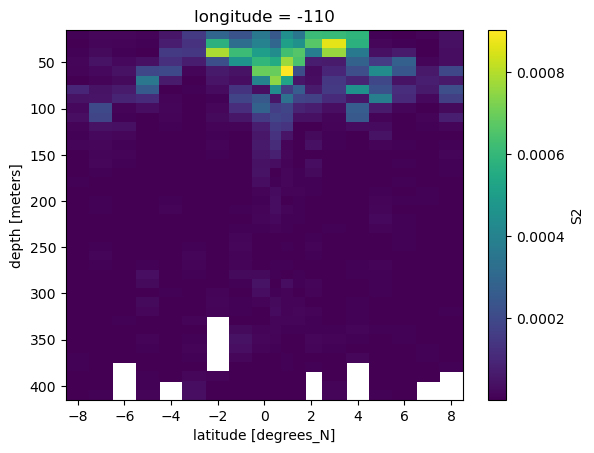

In [ ]:
binned.S2.plot(x="latitude", yincrease=False)

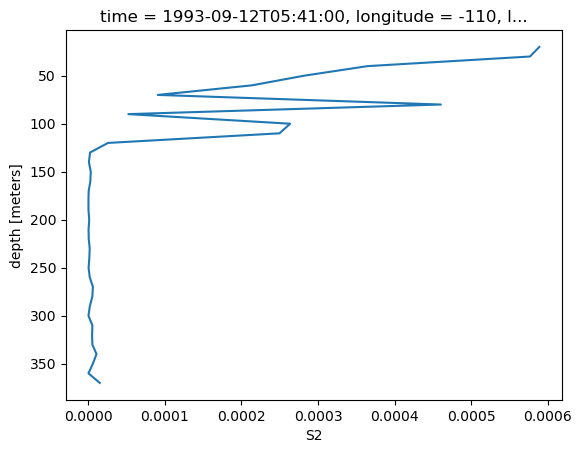

In [ ]:
binned.S2.sel(latitude=4, method="nearest").plot(y="depth", yincrease=False)

## summary plot for section

skipping 3.5
skipping 4.5


(<Figure size 1200x750 with 24 Axes>,
 {'sst': <matplotlib.axes._subplots.AxesSubplot at 0x2b344cf82ad0>,
  'Ri': <matplotlib.axes._subplots.AxesSubplot at 0x2b344cf86dd0>,
  'u': <matplotlib.axes._subplots.AxesSubplot at 0x2b344cfb8990>,
  'v': <matplotlib.axes._subplots.AxesSubplot at 0x2b344cf6c3d0>,
  'lats': [<matplotlib.axes._subplots.AxesSubplot at 0x2b344cf53a50>,
   <matplotlib.axes._subplots.AxesSubplot at 0x2b344d1a6a90>]})

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49730 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49732 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49736 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49744 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49748 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49750 remote=tcp://127.0.0.1:42035>


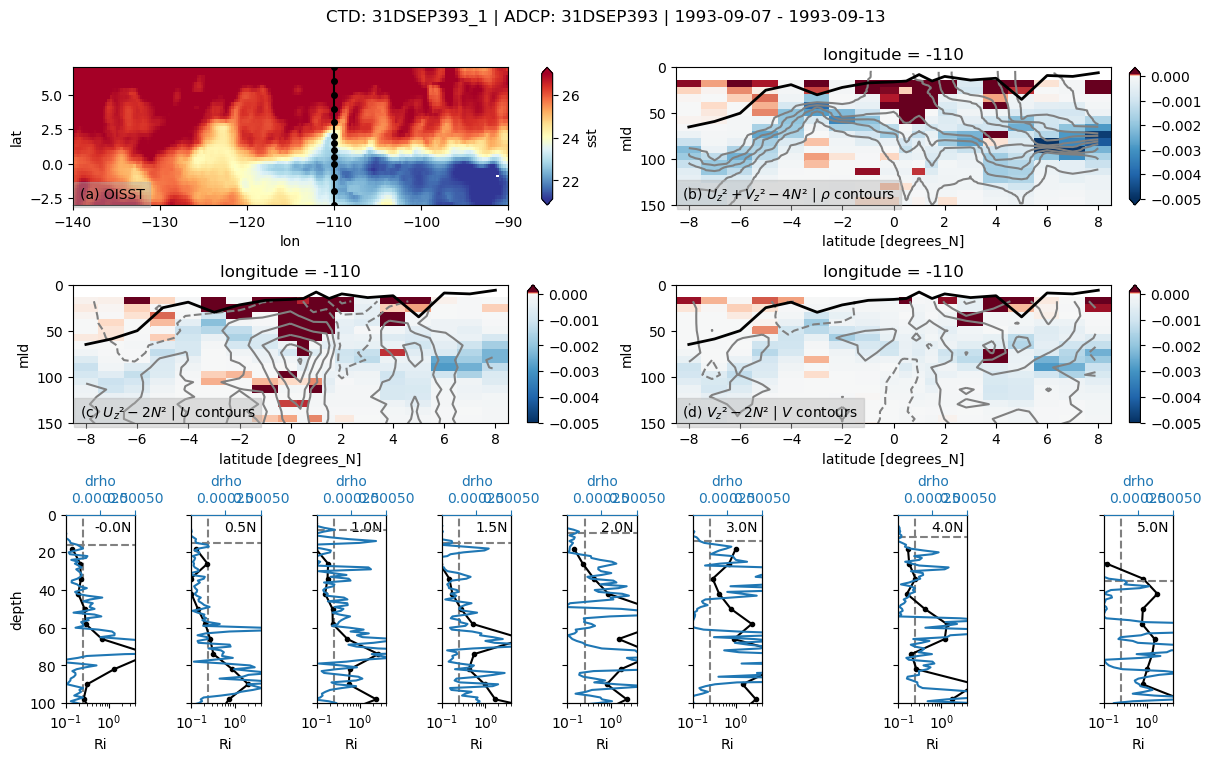

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49756 remote=tcp://127.0.0.1:42035>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:49758 remote=tcp://127.0.0.1:42035>


In [ ]:
%matplotlib inline

pump.sections.plot_section(ctd, adcp, binned, oisst)

/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


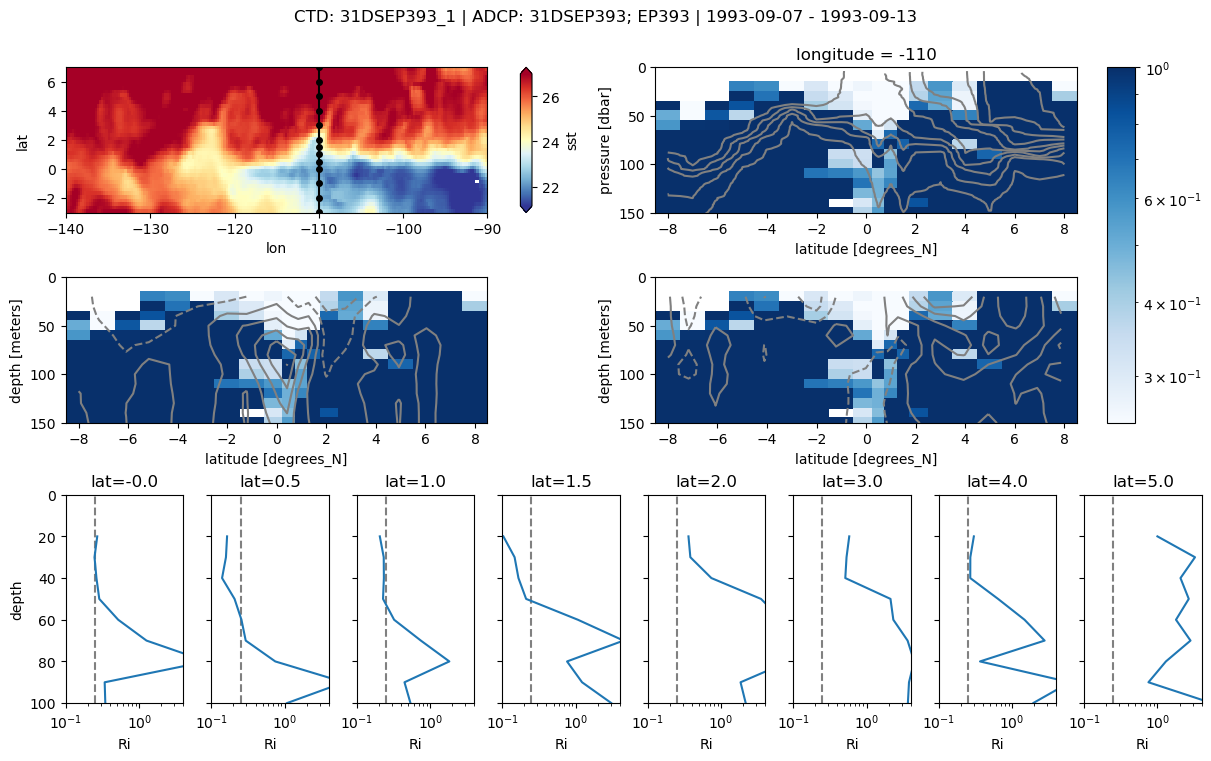

In [ ]:
pump.sections.plot_section(ctd, adcp, binned, oisst)

## LADCP test

Test out using SADCP instead of LADCP. Probably not a good diea since LADCP seems to be too smooth

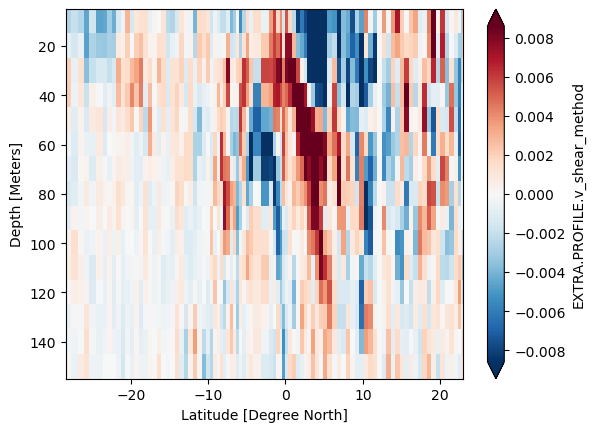

In [ ]:
ladcp["EXTRA.PROFILE.v_shear_method"].differentiate("depth").sel(depth=slice(150)).plot(
    x="lat", y="depth", robust=True, yincrease=False
)

In [ ]:
ladcp = (
    xr.open_mfdataset("../datasets/ladcp/33RO20071215_clivar_p18/*.nc")
    .rename({"z": "depth", "tim": "time", "lat": "latitude", "lon": "longitude"})
    .set_coords(["latitude", "longitude"])
)

dates = [
    "-".join(dd) for dd in ladcp.date.values[:, :3].astype("int").astype("U").tolist()
]
times = [
    ":".join(tt) for tt in ladcp.date.values[:, 3:].astype("int").astype("U2").tolist()
]
newtime = pd.DatetimeIndex(
    [pd.to_datetime(dd + " " + tt) for dd, tt in zip(dates, times)]
)
ladcp = (
    ladcp.rename({"time": "weird_time"})
    .assign_coords(time=("cast", newtime))
    .swap_dims({"cast": "time"})
)

ladcp.u.differentiate("depth").sel(depth=slice(150)).plot(
    robust=True, x="latitude", y="depth", yincrease=False
)

/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/glade/u/home/dcherian/python/xarray/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/glade/u/home/dcherian/python/xarray/xarray/plot/plot.py:1012: UserWarning: Attempted to set non-pos

/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


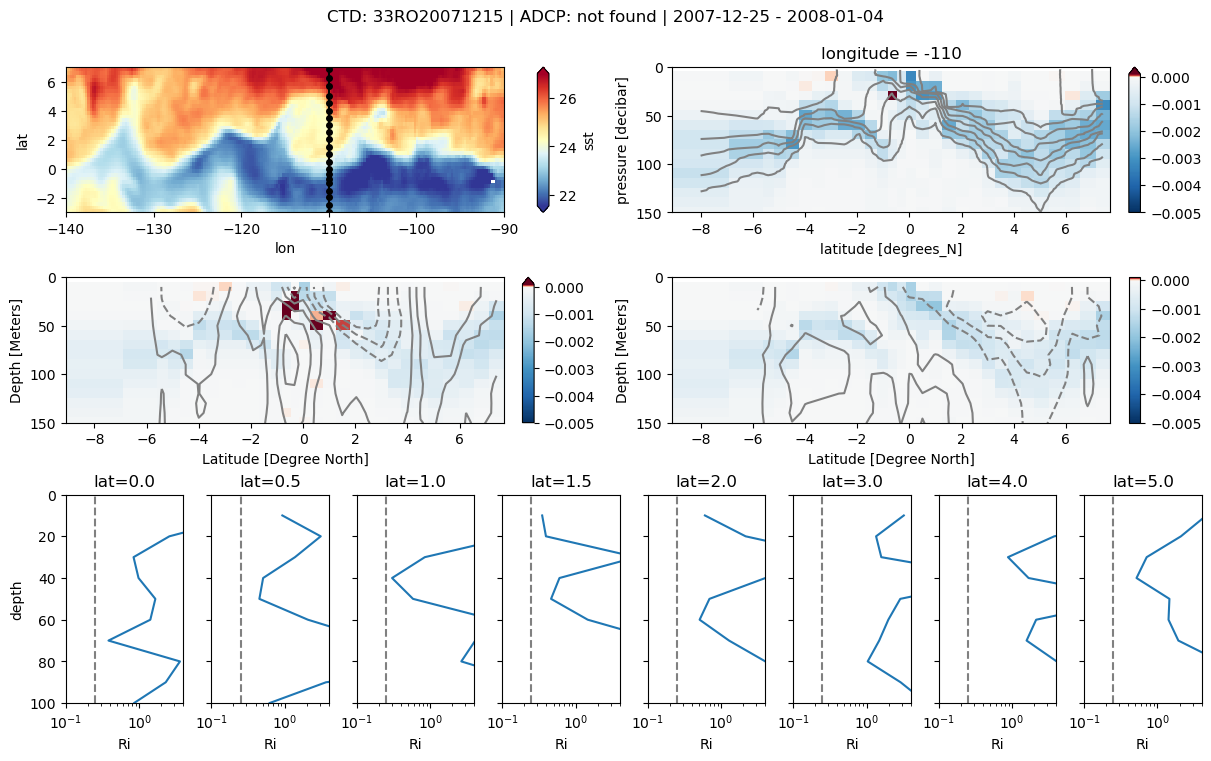

In [ ]:
f = pump.sections.plot_section(ctd, ladcp, ladcp_binned, oisst)

In [ ]:
ctd, ladcp = pump.sections.trim_ctd_adcp(ctd, ladcp)
ladcp_binned = pump.sections.grid_ctd_adcp(ctd, ladcp[["u", "v"]])

/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


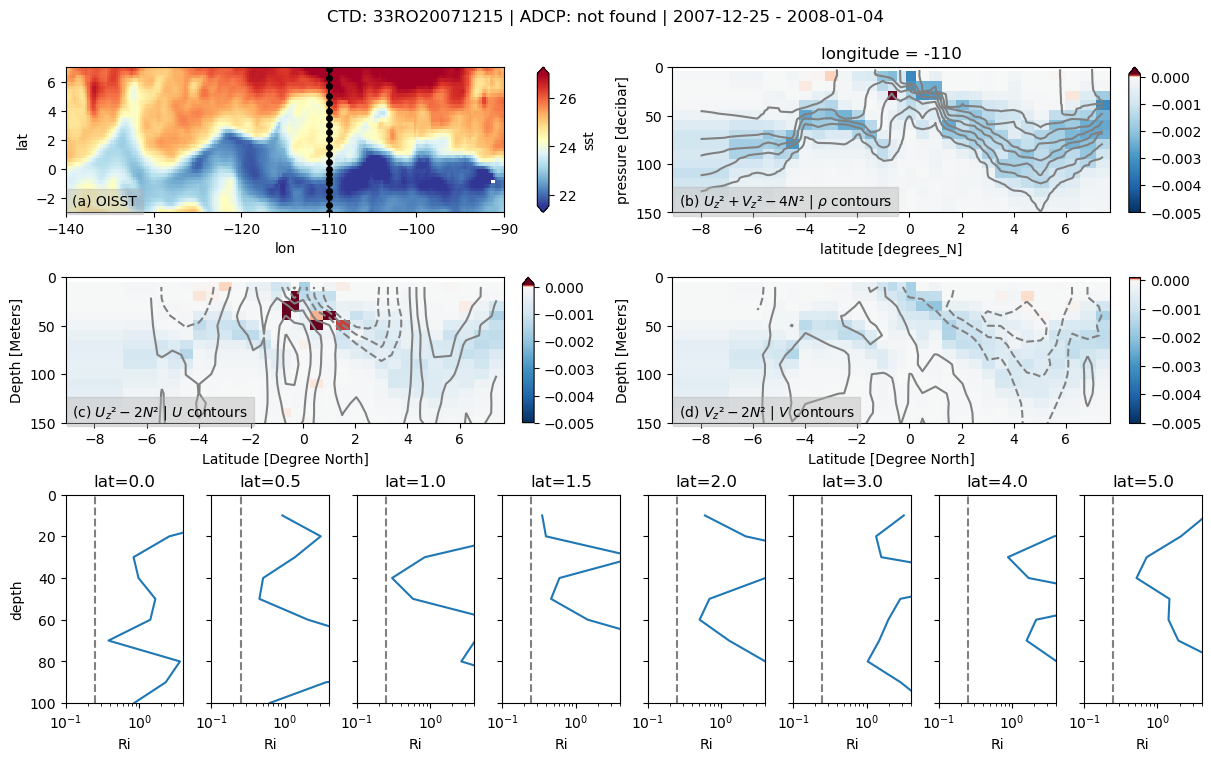

In [ ]:
%matplotlib inline
binned_l = pump.sections.grid_ctd_adcp(ctd, ladcp)
f, ax = pump.sections.plot_section(ctd, ladcp, binned_l, oisst)

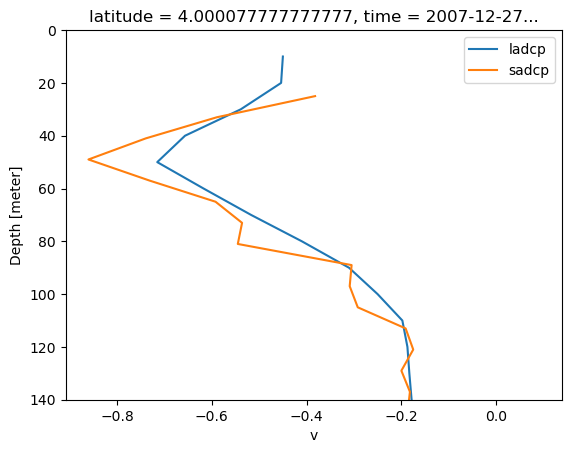

In [ ]:
ladcp.sel(latitude=slice(-1)).sel(latitude=4, method="nearest").v.plot(
    y="depth", yincrease=False
)
adcp.sel(latitude=4, method="nearest").v.plot(y="depth", yincrease=False, ylim=(140, 0))
plt.legend(["ladcp", "sadcp"])

R.C. and Ryan think that LADCP is pretty smoothed because of CTD cage motion. R.C. would definitely pick SADCP shear over LADCP to capture finer scale

## Save section images

In [ ]:
adcp_files

['../datasets/adcp/31DSEP391_1_00299v3.nc',
 '../datasets/adcp/31DSEP393_1_00210_short.nc',
 '../datasets/adcp/31DSEP692_2_00295v3.nc',
 '../datasets/adcp/33RB200311_1_RB0309_01032v3.nc',
 '../datasets/adcp/33RB200411_1_00899v3.nc',
 '../datasets/adcp/33RBGP602_1_00995v3.nc',
 '../datasets/adcp/33RBGP801_1_01007v3.nc',
 '../datasets/adcp/33RO20071215_rb0711_01079_short.nc',
 '../datasets/adcp/33RO20161119_RB1606_02292v3.nc']

Test image

31DSEP692
Found 31DSEP692 at index 10.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 1.5
skipping 3.5
skipping 4.5


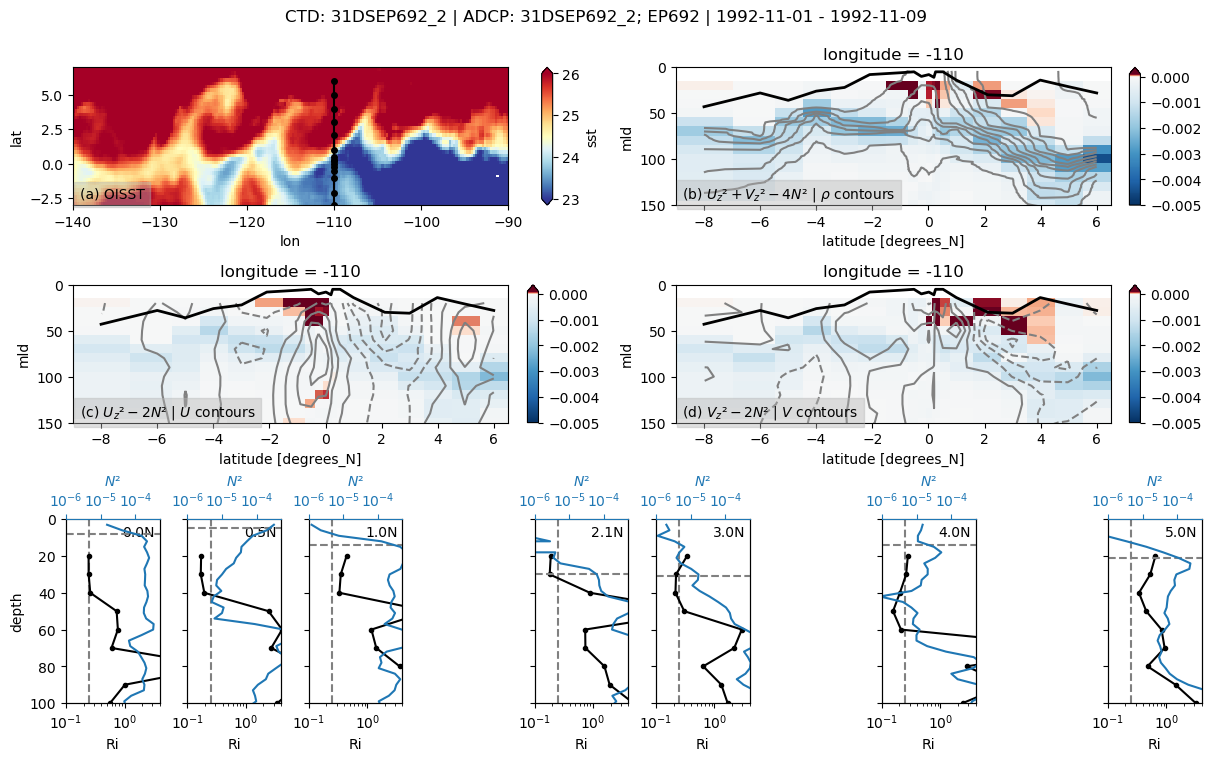

In [ ]:
for file in [adcp_files[2]]:
    expocode, ctd, adcp, binned = pump.sections.process_adcp_file(file)
    if expocode is not None:
        f, _ = pump.sections.plot_section(ctd, adcp, binned, oisst)

Loop through and save images

31DSEP391
Found 31DSEP391 at index 35.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 0.5
skipping 1
skipping 1.5
skipping 3
skipping 4
skipping 4.5
31DSEP393
Found 31DSEP393 at index 24.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 3.5
skipping 4.5
31DSEP692
Found 31DSEP692 at index 10.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 1.5
skipping 3.5
skipping 4.5
33RB200311
Found 33RB200311 at index 27.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 3.5
33RB200411
Found 33RB200411 at index 1.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 3.5
33RBGP602
Found 33RBGP602 at index 21.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 0.5
skipping 1.5
skipping 3.5
33RBGP801
Found 33RBGP801 at index 32.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


skipping 4.5
33RO20071215
Found 33RO20071215 at index 29.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


33RO20161119
Found 33RO20161119 at index 15.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


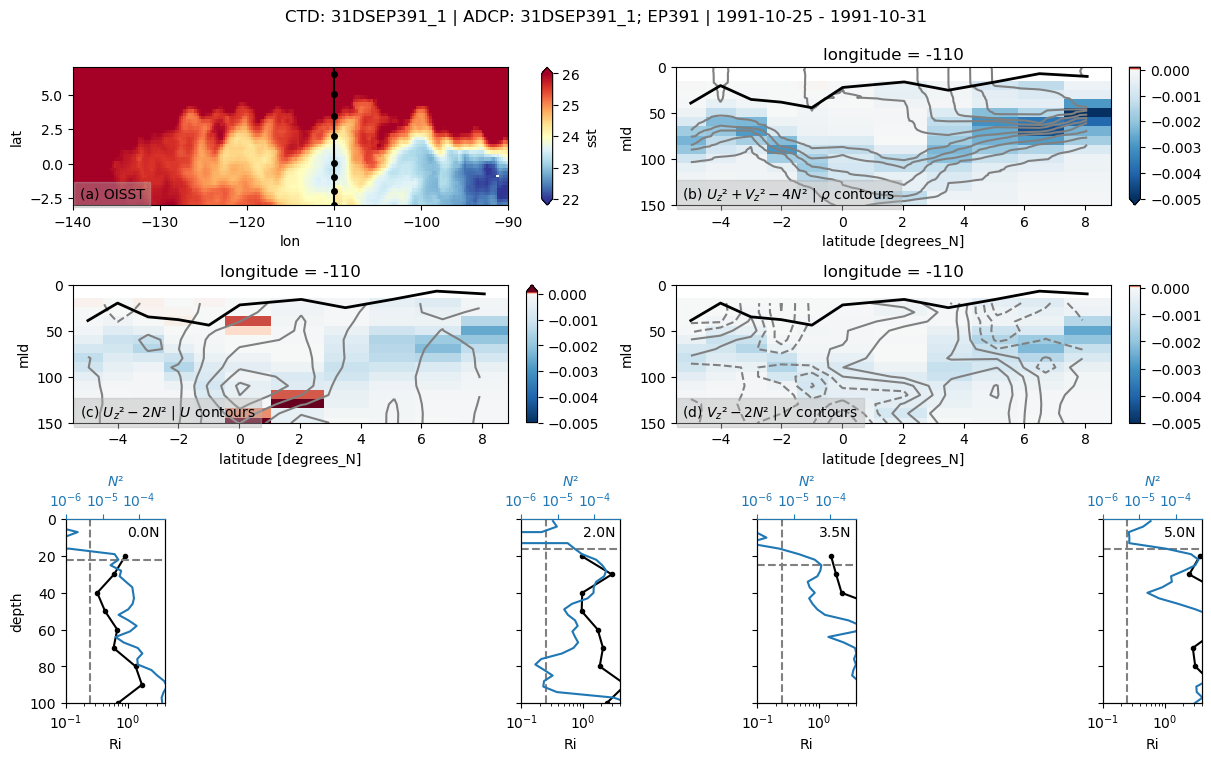

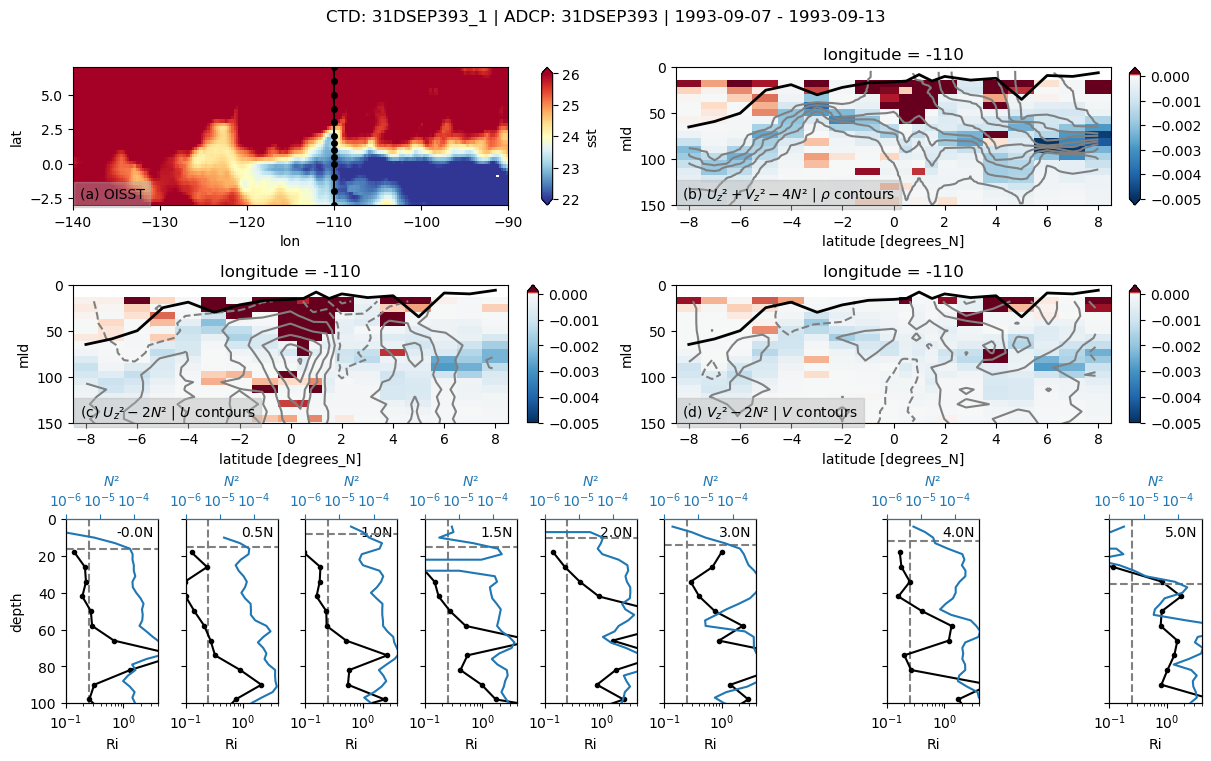

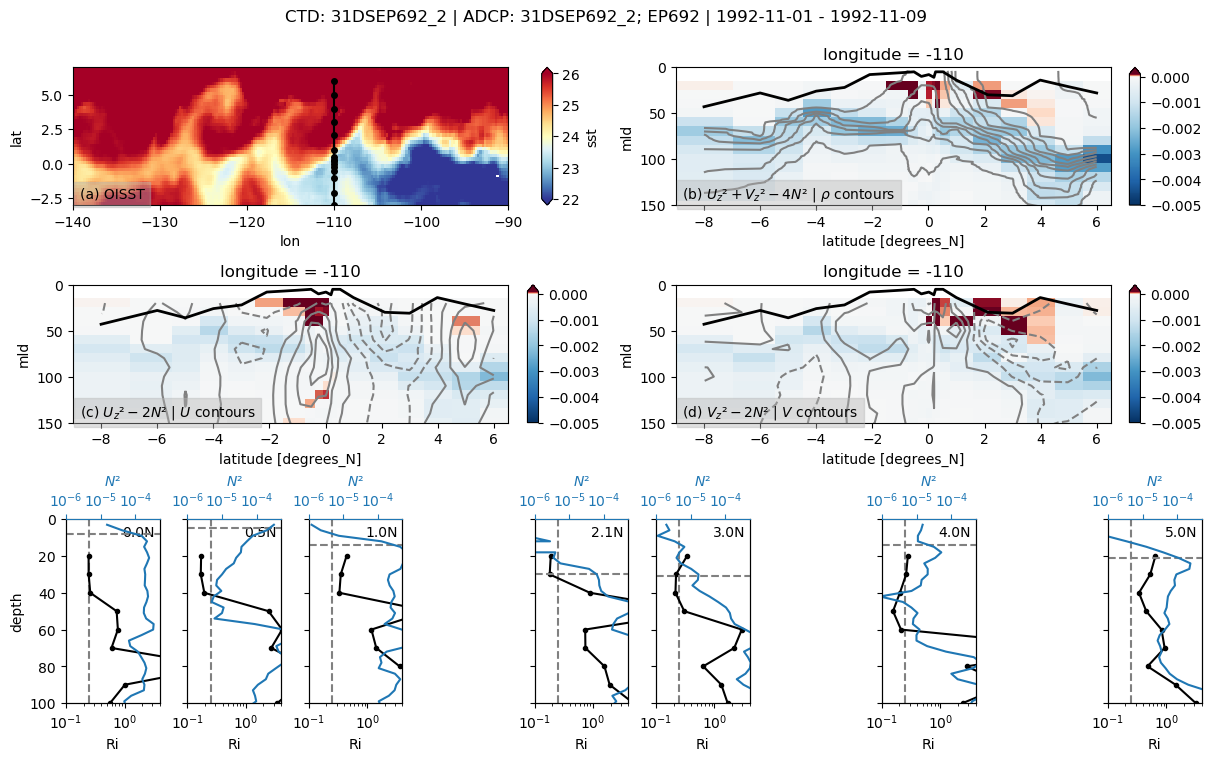

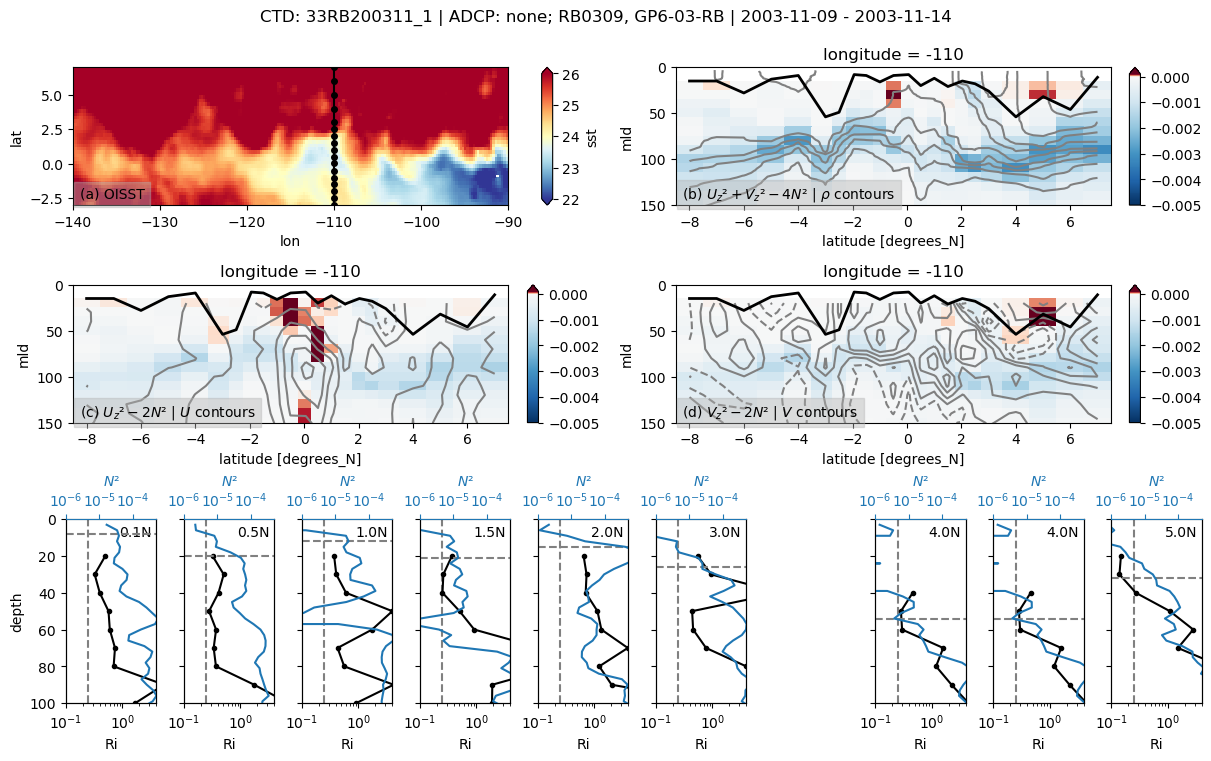

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50026 remote=tcp://127.0.0.1:46013>


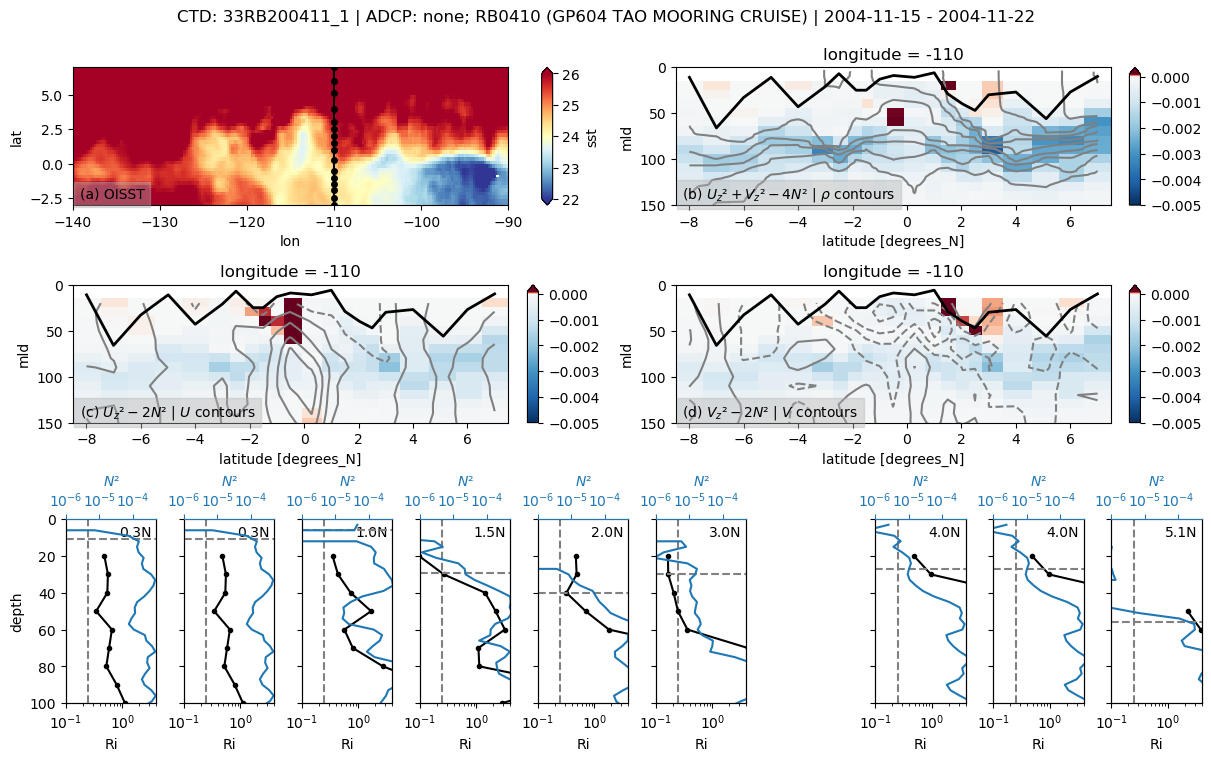

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50200 remote=tcp://127.0.0.1:46013>


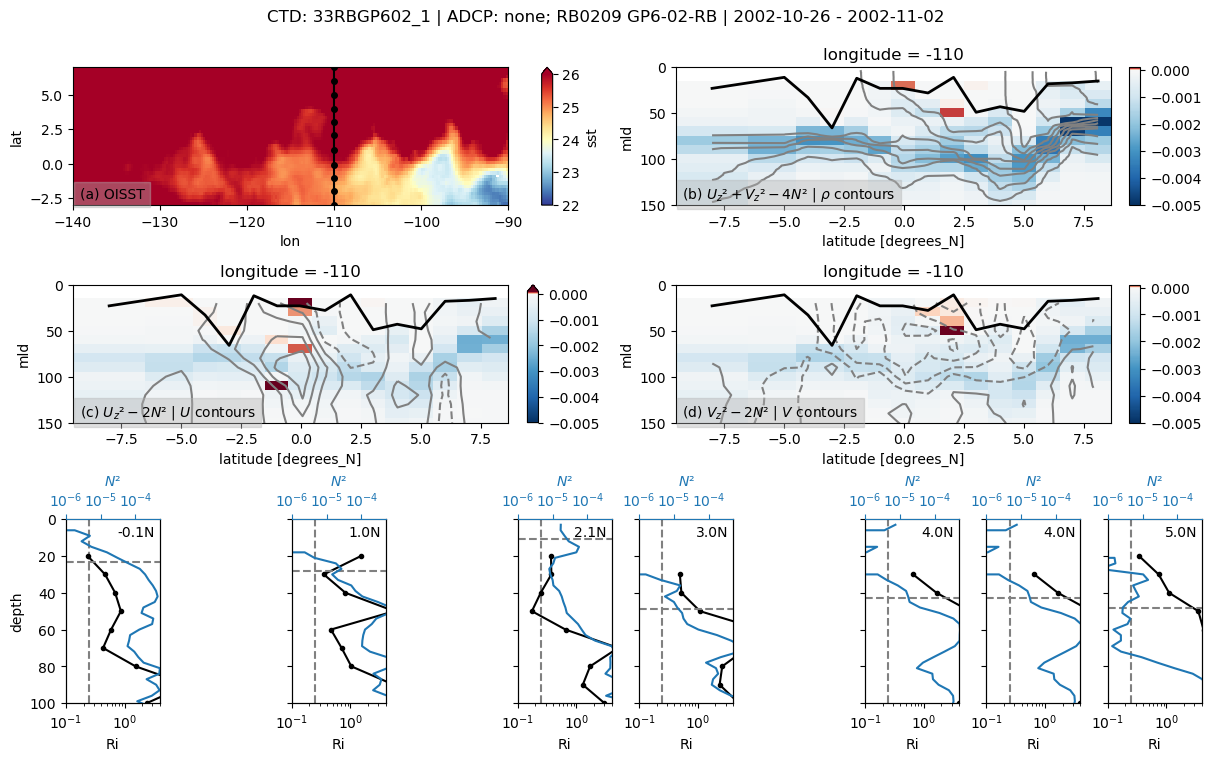

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:50422 remote=tcp://127.0.0.1:46013>


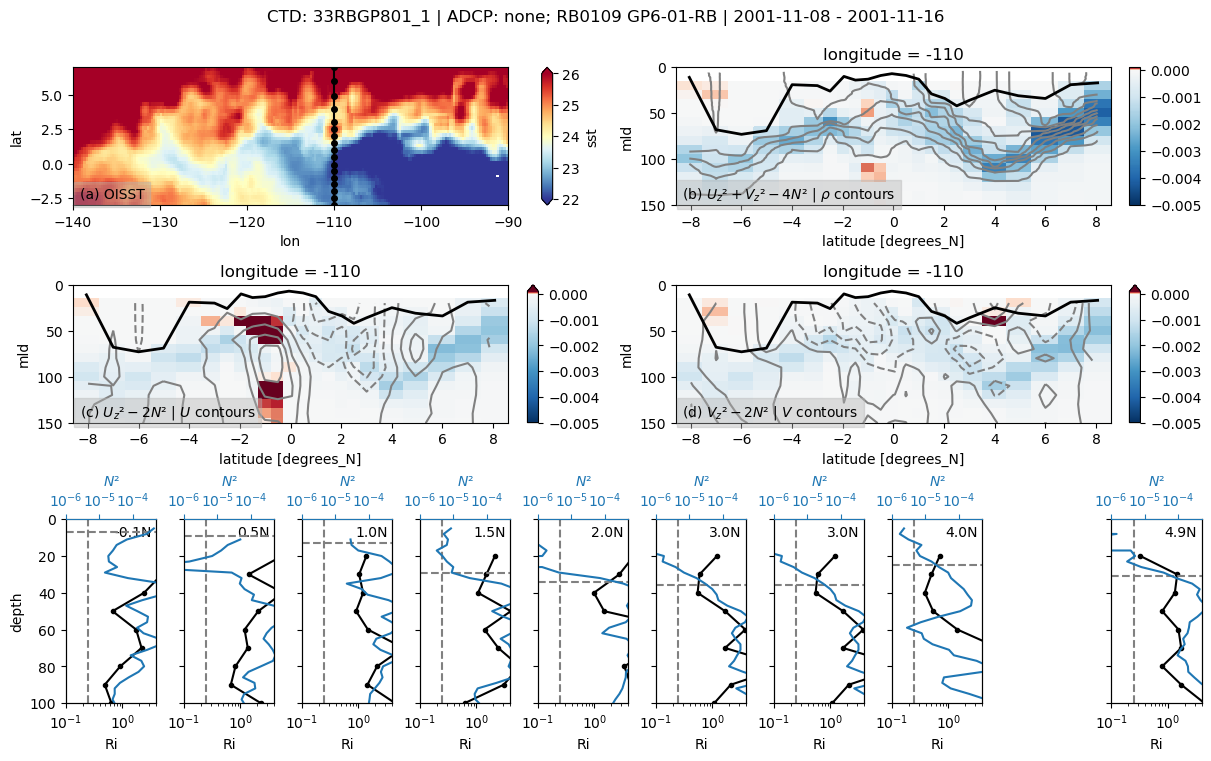

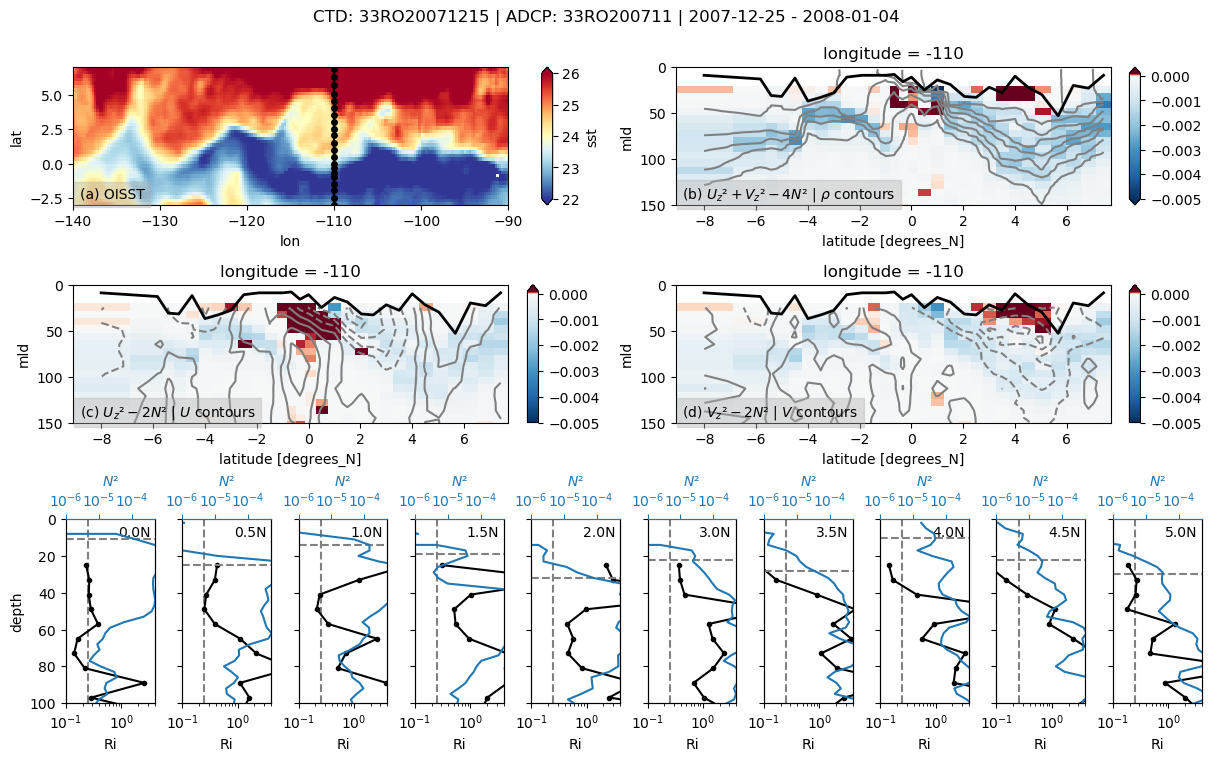

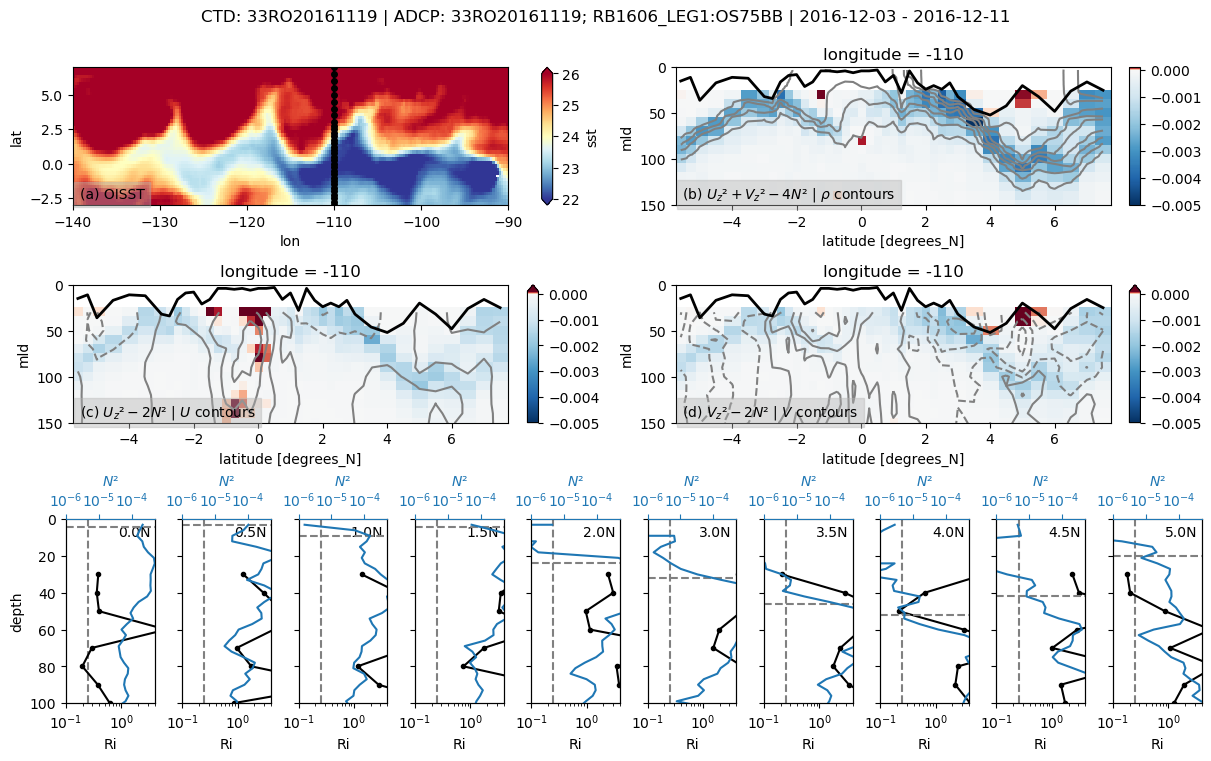

In [ ]:
%matplotlib inline


adcp_files = sorted(glob.glob("../datasets/adcp/*.nc"))
for file in adcp_files:  # [adcp_files[1]]:
    expocode, ctd, adcp, binned = pump.sections.process_adcp_file(file)
    if expocode is not None:
        f, _ = pump.sections.plot_section(ctd, adcp, binned, oisst)
        f.savefig(
            f"../images/cruise-sections/{expocode}.png", bbox_inches="tight", dpi=200
        )

## TIW DCL Paper figure

In [ ]:
from IPython import display

chosen_adcps = np.array(adcp_files)[[2, 1, 7]]

for file in chosen_adcps:
    ds = xr.open_dataset(file)
    if "cruise_sonar_summary" in ds.attrs:
        print(ds.attrs["cruise_sonar_summary"])
    else:
        display.display(ds.attrs)
    print("\n=======================================\n")

{'WOCE_Version': '3.0',
 'CONVENTIONS': 'COARDS/WOCE',
 'DATA_TYPE': 'TRACK',
 'DATA_SUB_TYPE': 'SADCP',
 'INST_TYPE': 'SADCP',
 'DATA_ORIGIN': '               NOAA/PMEL; EARTH AND SPACE RESEARCH',
 'EXPOCODE': '31DSEP692_2 ',
 'WOCE_ID': 'PR16 ',
 'CRUISE_NAME': 'EP692',
 'DAC_ID': '00295',
 'FILE_SOURCE': '00295.sub',
 'file_date': '12 Apr 2002',
 'TIME_INTERVAL_BETWEEN_DATA': 'hour',
 'TIME_AVERAGING_SCHEME': 'mean centered on hour',
 'DEPTH_INTERVAL_BETWEEN_DATA': '10 meters',
 'DEPTH_AVERAGING_SCHEME': 'mean centered on given depth',
 'SHIP_POSITION': 'average over hour',
 'doc_000': 'The following time, space, and depth ranges for this cruise',
 'doc_001': 'are based on the complete high-resolution data set and does',
 'doc_002': 'not agree exactly with the ranges of this averaged subset.',
 'doc_003': ' #DATA_DATES: 1992/10/15 00:01:00 --- to --- 1992/11/19 23:26:00',
 'doc_004': ' #LON_RANGE: 117.23 W --- to ---  80.87 W',
 'doc_005': ' #LAT_RANGE:  10.00 S --- to ---  32.72 N'



 #DATA_DATES: 1993/08/24 01:45:00 --- to --- 1993/09/18 16:08:00
 #LON_RANGE: 117.23 W --- to ---  94.88 W
 #LAT_RANGE:   8.05 S --- to ---  32.72 N
 #DEPTH_RANGE:     18 --- to --- 522 m
 #SAC_CRUISE_ID: 00210 
 #PLATFORM_NAME: R/V Discoverer
 #PRINCIPAL_INVESTIGATOR_NAME:  M.McPhaden and Eric Johnson
 #PI_INSTITUTION:               NOAA/PMEL; Earth and Space Research
 #PI_COUNTRY:                   USA
 #PROJECT: WOCE (Repeat Survey) 
           Tropical Atmosphere Ocean (TOGA/TAO) mooring cruises
 #CRUISE_NAME: ship_tag=ep393 woce_tag=PR16 EXPOCODE=31DSEP393  
 #PORTS: San Diego to San Diego
 #GEOGRAPHIC_REGION: E Pacific, tropical E Pacific
 #PROCESSED_BY: P.Plimpton (NOAA/PMEL) and Eric Johnson (Earth and 
                Space Research)
 #NAVIGATION: GPS                          
 #QUALITY_NAV: good
 #GENERAL_INFORMATION: 
CRUISE NOTES
  CHIEF SCIENTIST ON SHIP     : unconfirmed
    INSTITUTE                 : NOAA/PMEL
    COUNTRY                   : USA
  SIGNIFICANT DATA GAP

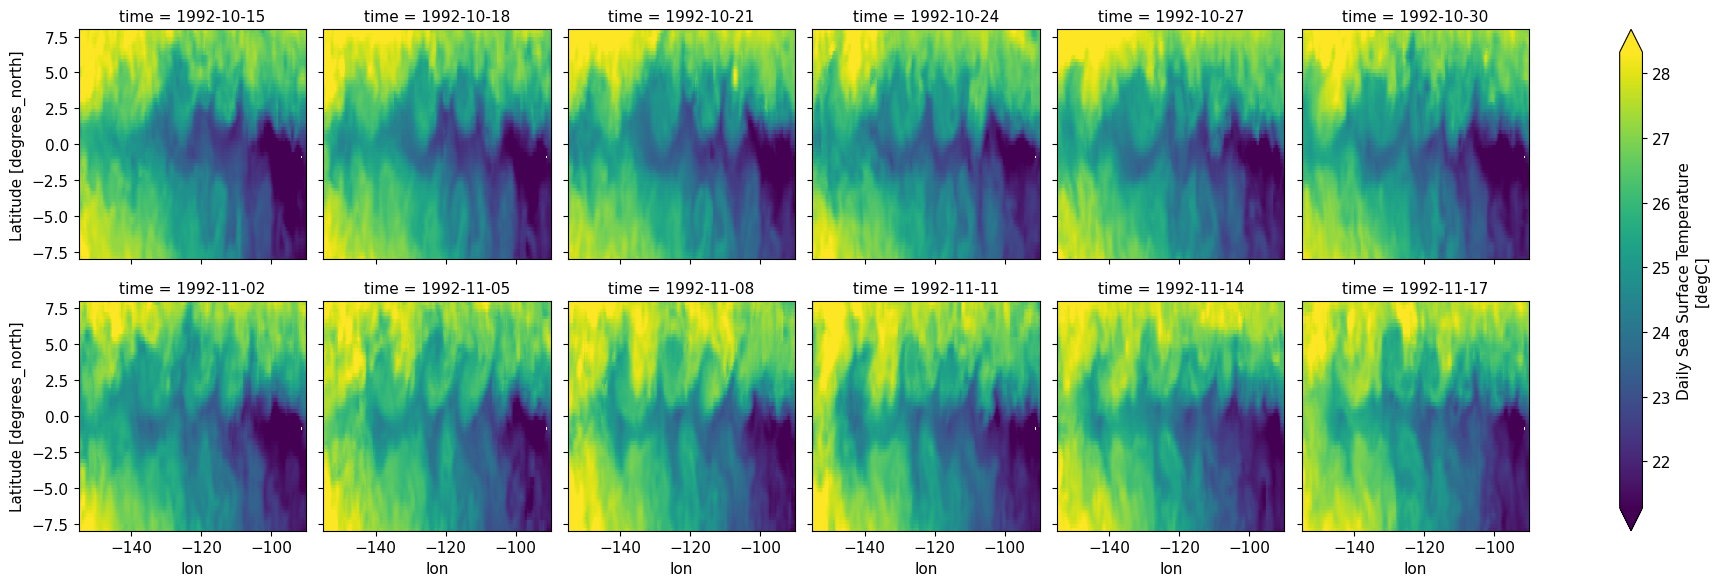

In [ ]:
oisst.sel(time=slice("1992-10-15", "1992-11-19")).isel(time=slice(None, None, 3)).plot(
    col="time", col_wrap=6, robust=True
)

In [ ]:
?pump.sections.process_adcp_file

Signature: pump.sections.process_adcp_file(adcp_file: str)
Docstring: processes an adcp adcp_file; finds matching CTD section. 
File:      ~/pump/pump/sections.py
Type:      function


../datasets/adcp/31DSEP692_2_00295v3.nc
31DSEP692
Found 31DSEP692 at index 10.


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


['1992-11-02T00:40:00.000000000']


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


../datasets/adcp/31DSEP393_1_00210_short.nc
31DSEP393
Found 31DSEP393 at index 24.
['1993-09-12T05:41:00.000000000']


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


../datasets/adcp/33RO20071215_rb0711_01079_short.nc
33RO20071215
Found 33RO20071215 at index 29.


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


['2007-12-26T11:13:00.000000000']


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/dcpy/dcpy/plots.py:968: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xlabel("")


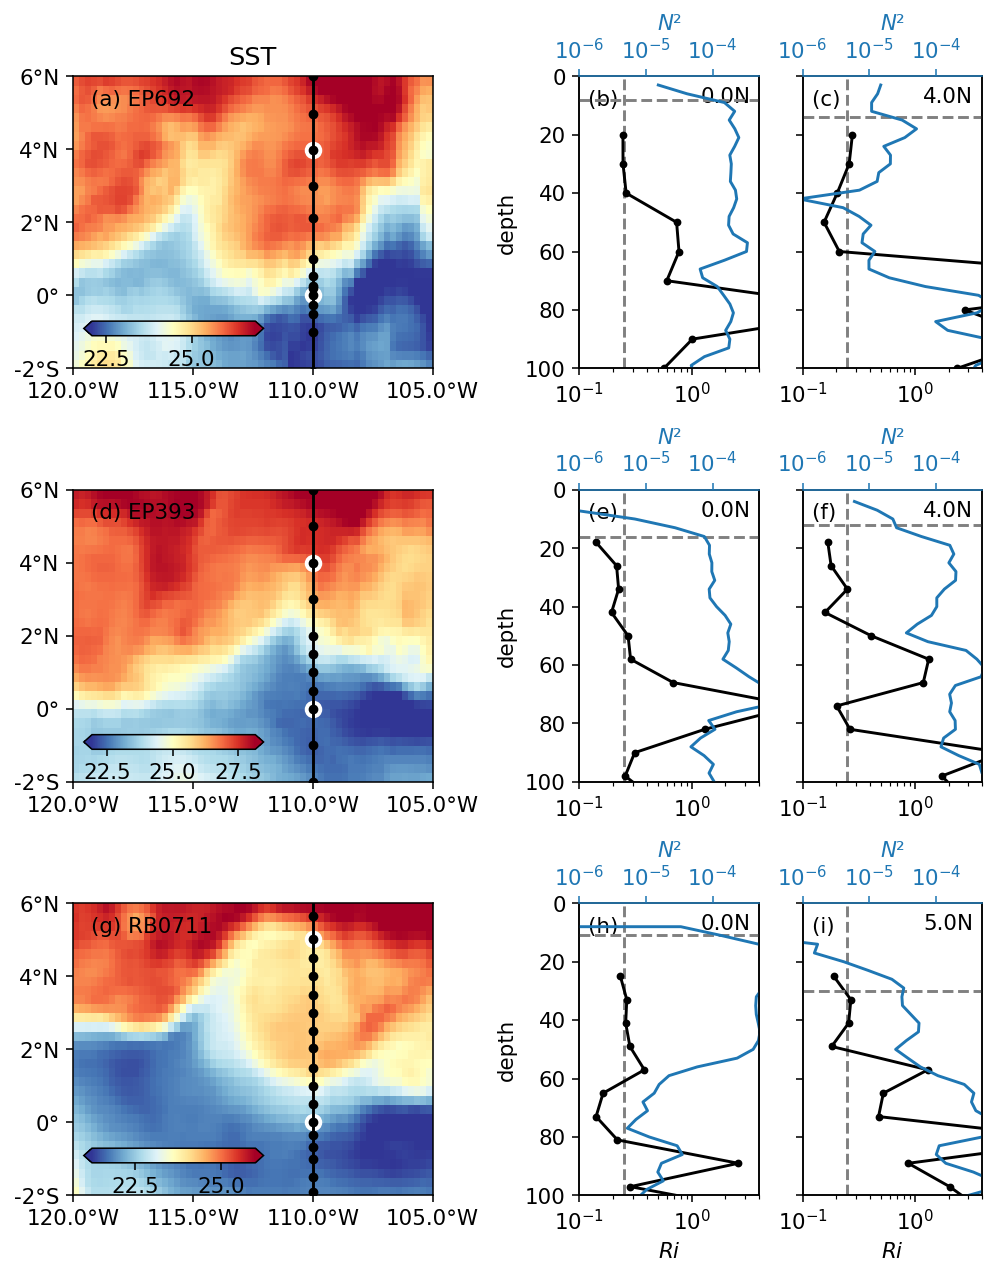

In [ ]:
%matplotlib inline
import dask
import os


plt.rcParams["font.size"] = 11

f, ax = plt.subplots(
    3,
    3,
    gridspec_kw=dict(width_ratios=[2, 1, 1]),
    # sharex="col",
    sharey="col",
    constrained_layout=True,
)

expected_lat = [0, 1, 3, 4]
axrho = []
for index, (file, lats) in enumerate(
    zip(
        chosen_adcps,
        [
            [0, 4],
            [0, 4],
            [0, 5],
        ],
    )
):
    print(file)
    expocode, ctd, adcp, binned = dask.compute(
        *pump.sections.process_adcp_file(file, cruises)
    )
    axx = dict()
    axx["sst"] = ax[index, 0]
    axx["lats"] = ax[index, 1:]

    axrho.append(pump.sections.plot_row(ctd, adcp, binned, oisst, axx, lats))

[axx.set_xlabel("") for axx in ax[:-1, :].flat]
[aa.set_yticks([-2, 0, 2, 4, 6]) for aa in ax[:, 0]]
[dcpy.plots.lat_lon_ticks(aa) for aa in ax[:, 0]]

dcpy.plots.label_subplots(
    ax.flat, labels=["EP692", "", "", "EP393", "", "", "RB0711", "", ""]
)
ax[0, 0].set_title("SST")
f.set_size_inches((7, 9))
f.savefig("images/cruise-Ri-summary.png")

## OSM20 figure

In [ ]:
expocode, ctd, adcp, binned = process_file(adcp_files[1])

31DSEP393
Found 31DSEP393 at index 24.


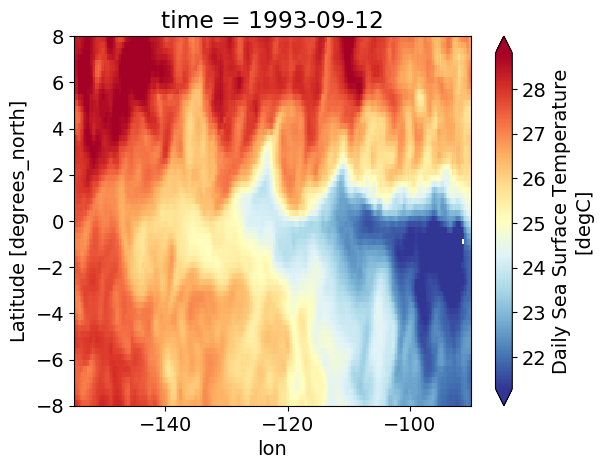

In [ ]:
oisst.sel(time="1993-").plot(robust=True, cmap=mpl.cm.RdYlBu_r)

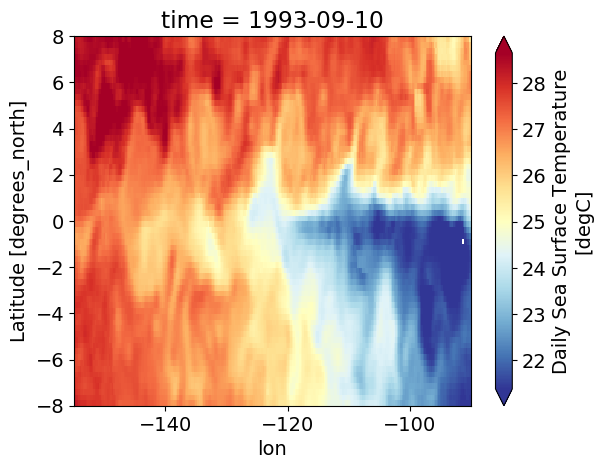

In [ ]:
oisst.sel(
    time=ctd.time.sel(latitude=0, method="nearest").time.values, method="nearest"
).plot(cmap=mpl.cm.RdYlBu_r, robust=True)

../datasets/adcp/31DSEP692_2_00295v3.nc
31DSEP692
Found 31DSEP692 at index 10.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


../datasets/adcp/31DSEP393_1_00210_short.nc
31DSEP393
Found 31DSEP393 at index 24.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


../datasets/adcp/33RO20071215_rb0711_01079_short.nc
33RO20071215
Found 33RO20071215 at index 29.


/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


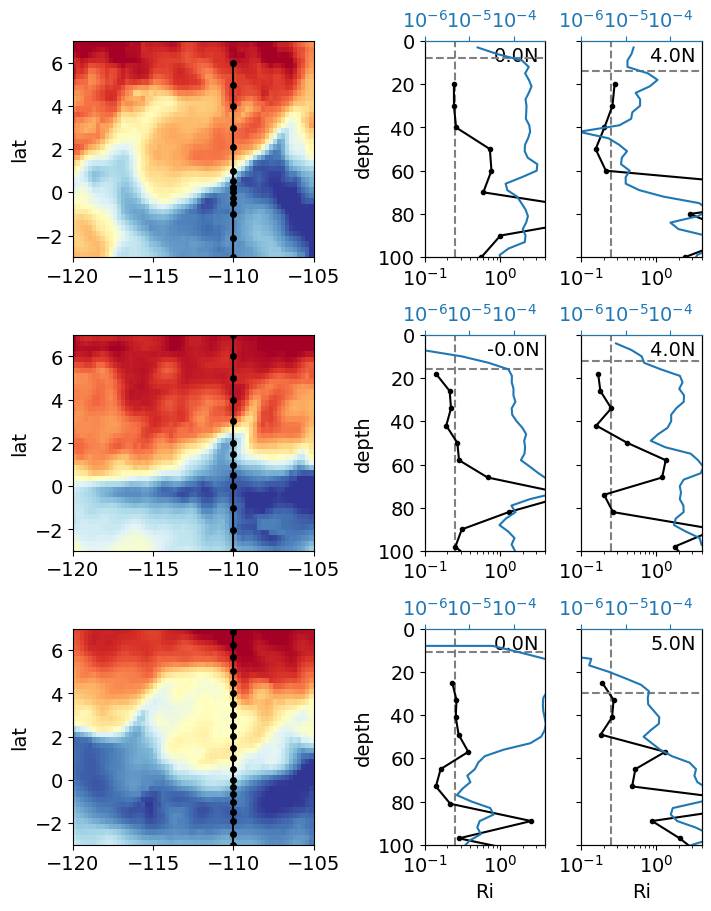

In [ ]:
%matplotlib inline

plt.rcParams["font.size"] = 14

f, ax = plt.subplots(
    3,
    3,
    gridspec_kw=dict(width_ratios=[2, 1, 1]),
    # sharex="col",
    sharey="col",
    constrained_layout=True,
)

expected_lat = [0, 1, 3, 4]

for index, (file, lats) in enumerate(
    zip(
        np.array(adcp_files)[[2, 1, 7]],
        [
            [0, 4],
            [0, 4],
            [0, 5],
        ],
    )
):
    print(file)
    expocode, ctd, adcp, binned = process_file(file)
    axx = dict()
    axx["sst"] = ax[index, 0]
    axx["lats"] = ax[index, 1:]

    pump.sections.plot_row(ctd, adcp, binned, oisst, axx, lats)

[axx.set_xlabel("") for axx in ax[:-1, :].flat]
f.set_size_inches((7, 9))
# f.savefig("cruise-Ri-summary.png")

## debug particular sections

### CLIVAR P18 2007

In [ ]:
file = "../datasets/adcp/33RO20071215_rb0711_01079_short.nc"
expocode = os.path.split(file)[-1].split("_")[0].strip()
ctd = pump.sections.find_cruise(cruises, expocode)
adcp = pump.sections.read_adcp(file, -110)
ctd = ctd.sortby("time")
ctd, adcp = pump.sections.trim_ctd_adcp(ctd, adcp)

Found 33RO20071215 at index 29.


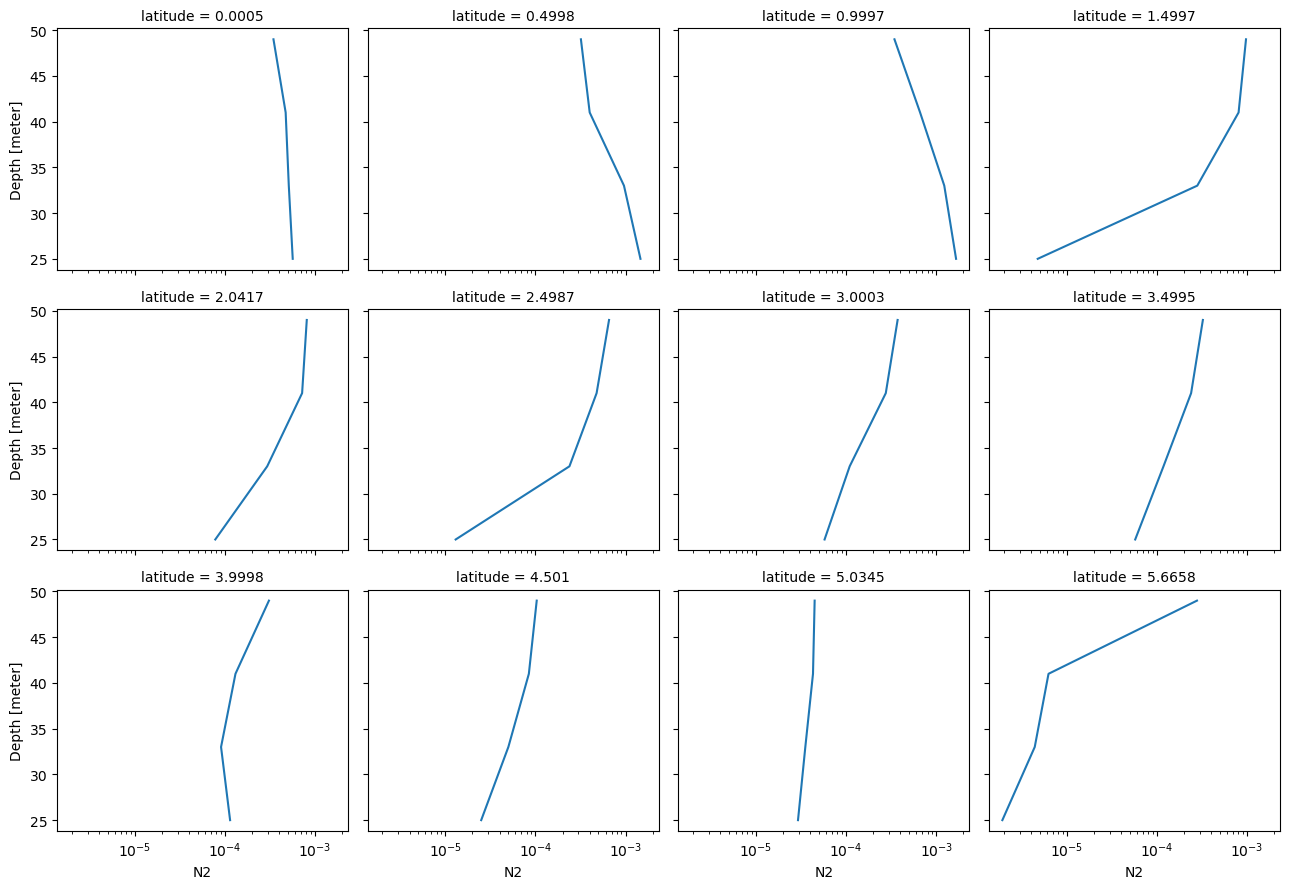

In [ ]:
binned.N2.sortby("latitude").sel(latitude=slice(0, 6), depth=slice(0, 50)).plot.line(
    col="latitude", col_wrap=4, y="depth", xscale="log"
)

/glade/u/home/dcherian/python/xarray/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


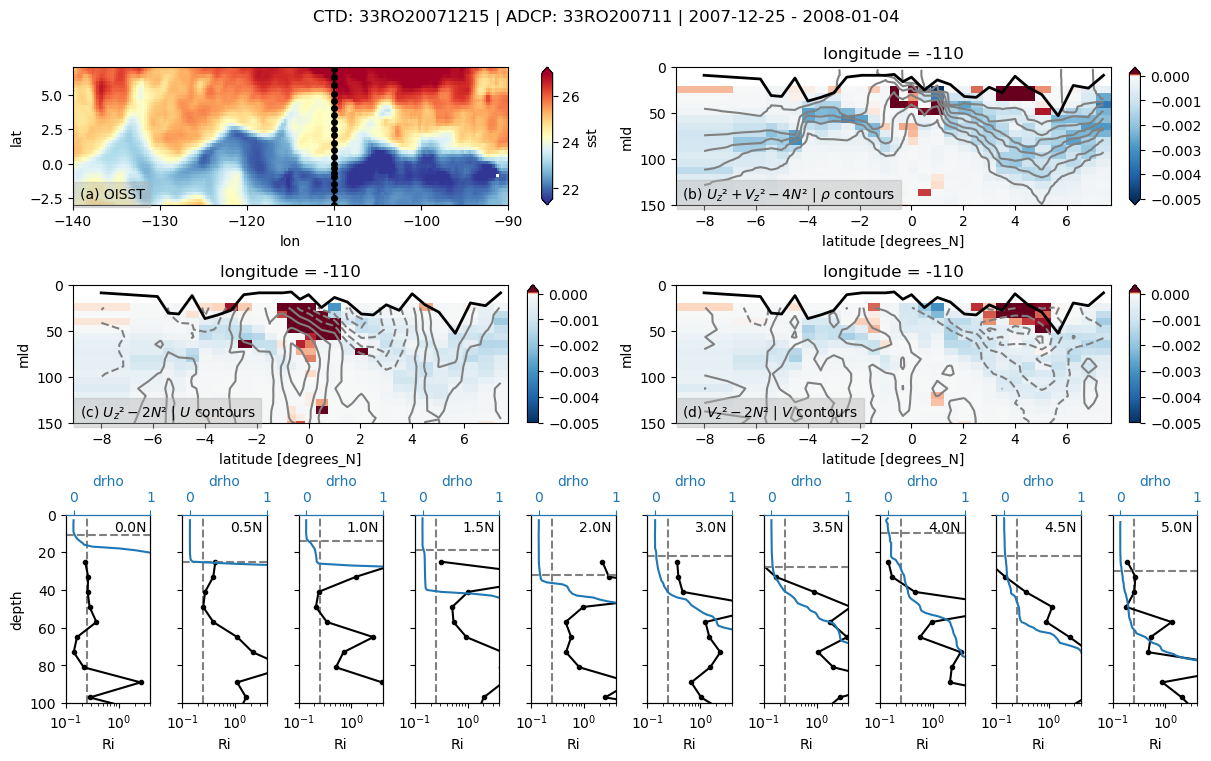

In [ ]:
%matplotlib inline
binned = pump.sections.grid_ctd_adcp(ctd, adcp)
f, ax = pump.sections.plot_section(ctd, adcp, binned, oisst)

In [ ]:
f.savefig(f"../images/cruise-sections/33RO20071215.png", bbox_inches="tight", dpi=200)

### Discoverer EP391

/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


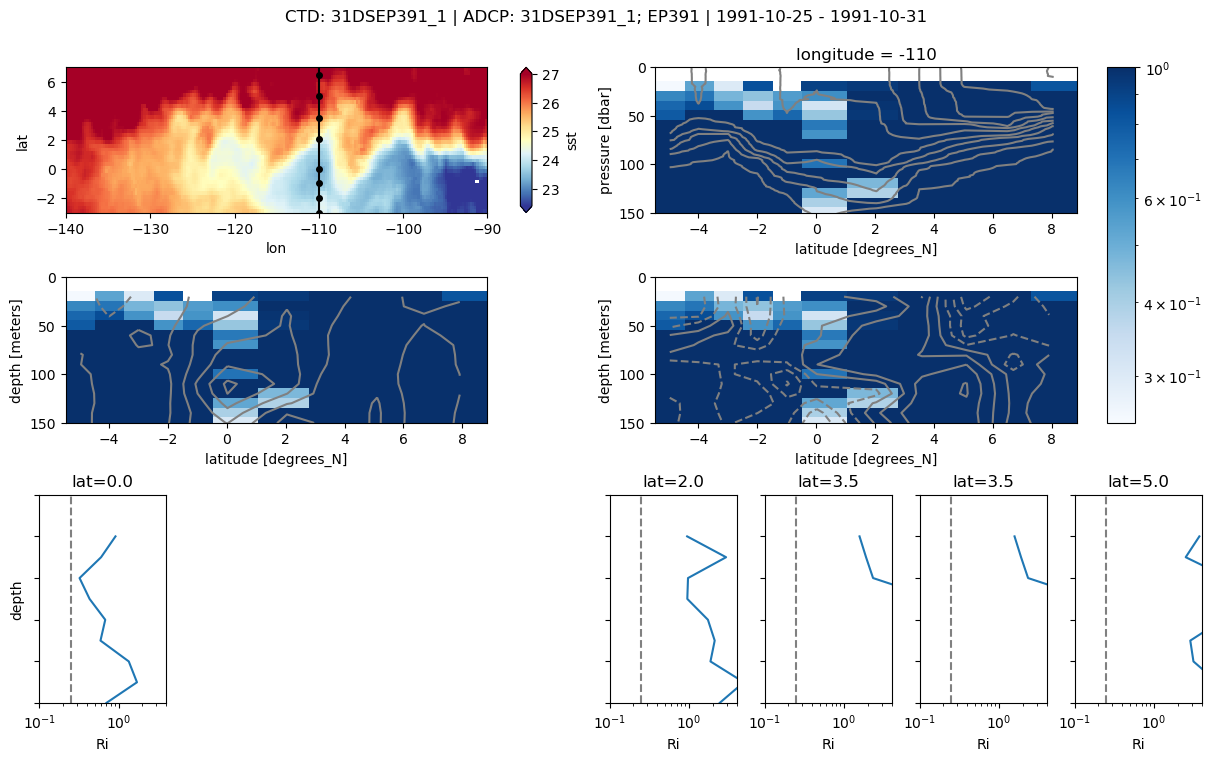

In [ ]:
# _, ctd, adcp, binned = process_file(adcp_files[0])
f = plot_section(ctd, adcp, binned);

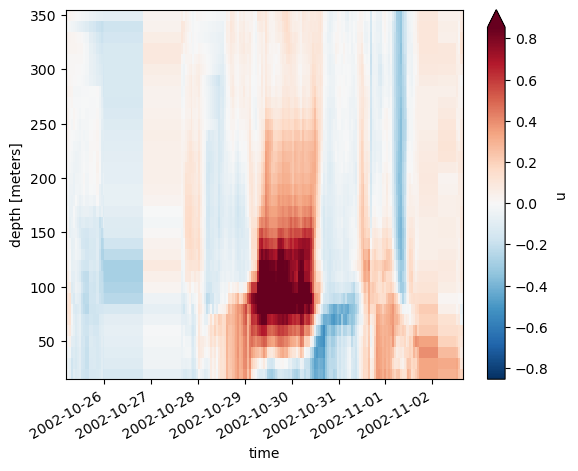

In [ ]:
adcp.u.plot(x="time", robust=True)

## test plots

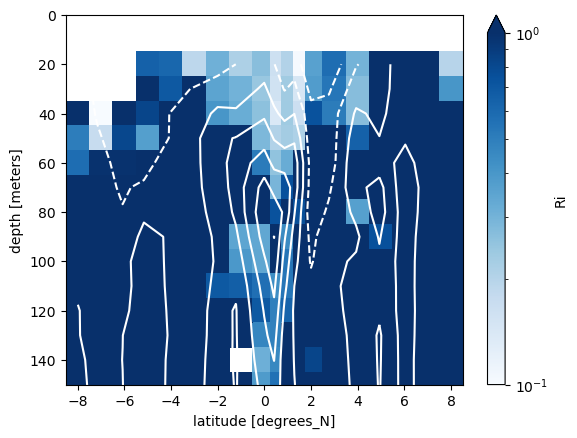

In [ ]:
binned.Ri.plot(
    y="depth", yincrease=False, norm=mpl.colors.LogNorm(0.1, 1), cmap=mpl.cm.Blues
)
adcp.u.plot.contour(y="depth", colors="w", levels=10, ylim=(150, 0))

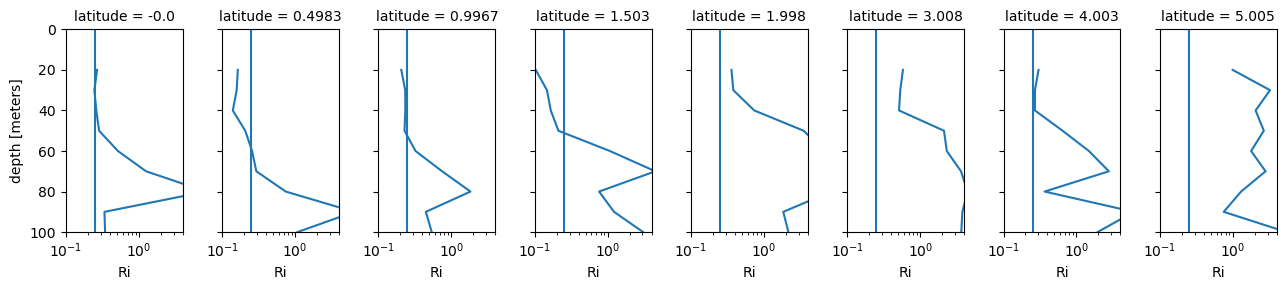

In [ ]:
fg = binned.Ri.sel(latitude=slice(0, 6)).plot(
    col="latitude",
    y="depth",
    xscale="log",
    yincrease=False,
    xlim=(0.1, 4),
    ylim=(100, 0),
    aspect=1 / 2,
)
[ax.axvline(0.25) for ax in fg.axes.flat]

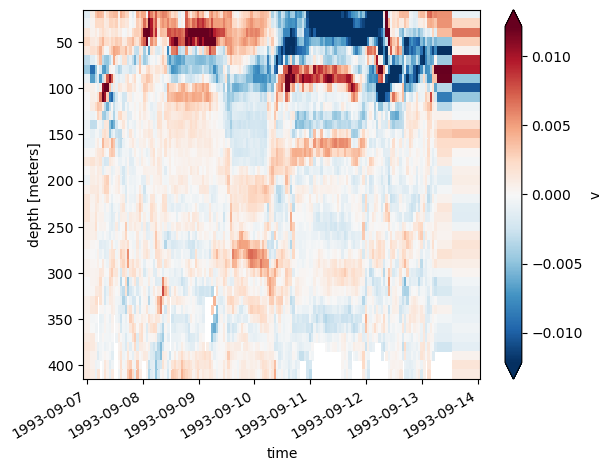

In [ ]:
adcp.v.differentiate("depth").plot(x="time", y="depth", yincrease=False, robust=True)